In [10]:
import networkx as nx
import matplotlib.pyplot as plt

In [11]:
def node_label(position, cf, ctp):
  return str(position) + ':' + str(cf) + ',' + str(ctp)

## Pruning Functons

In [12]:
# remove all nodes unreachable from a first node

def remove_unreachable_nodes(graph):
    """
    Remove nodes from a NetworkX graph that are not on a path to any of the specified nodes.

    Args:
        G (nx.Graph or nx.DiGraph): The input graph.
        specified_nodes (list): List of nodes that are considered reachable.

    Returns:
        nx.Graph or nx.DiGraph: The modified graph with unreachable nodes removed.
    """
    # find first nodes
    nodes = list(graph.nodes())
    first_nodes = []
    for node in nodes:
      index = int(node.split(':')[0])
      if index == 0:
        first_nodes.append(node)
      
    # Create a set of reachable nodes
    reachable_nodes = set(first_nodes)

    # Perform a breadth-first search from each specified node and add all reachable nodes to the set
    for node in first_nodes:
        reachable_nodes.update(nx.descendants(graph, node))

    # Get the set of nodes that are not reachable
    unreachable_nodes = set(graph.nodes()) - reachable_nodes

    # Remove the unreachable nodes from the graph
    graph.remove_nodes_from(unreachable_nodes)

    # Return the modified graph with unreachable nodes removed
    return graph

In [13]:
# remove nodes not on a path to a final node

def remove_unreaching_nodes(graph, final_index):
  """Remove nodes from a NetworkX graph that do not have a path to any of the
  nodes in the input array.

  Args:
      G (nx.Graph or nx.DiGraph): The input graph.
      nodes (list): List of nodes that are considered reachable.

  Returns:
      nx.Graph or nx.DiGraph: The modified graph with unreachable nodes removed.
  """
  # Create a list of last nodes
  nodes = list(graph.nodes())
  final_nodes = []
  for node in nodes:
    index = int(node.split(':')[0])
    if index == final_index:
      final_nodes.append(node)
  on_path = []

  # add all nodes on a path to the end to on_path.
  
  while nodes:
    node = nodes.pop()
    is_on_path = None
    for final_node in final_nodes:
      if final_node.__contains__(node):
        is_on_path = True
      elif not is_on_path:
        descendants = (nx.descendants(graph, node))
        if descendants.__contains__(final_node):
          is_on_path = True
    if is_on_path:
      on_path.append(node)
  
  # Create a set of all of the nodes that do not have a path to any of the specified nodes.
  
  unreaching_nodes = set(graph.nodes()) - set(on_path)
  
  # Remove all of the unreaching nodes from the graph.
  for node in unreaching_nodes:
    graph.remove_node(node)
  
  return graph

In [14]:
# only works with first species and ctp above
def find_nodes_and_edges(melody_data):
    melody = melody_data["melody"]
    final_index = len(melody) - 1
    
    all_possibilities = dict()
    
    nodes = list()
    final_nodes = list()
    first_nodes = list()
    edges = list()
    
    # find all possible nodes
    for i in range(0, len(melody)):
        note = melody[i]
        current = all_possibilities[i] = []
        
        # get possible counterpoint notes
        if i == 0 or i == final_index:
            possible_ctps = [note, note + 7, note + 12, note + 19]
        elif i == final_index - 1:
            if note > 0:
              possible_ctps = [note + 9]
            elif note < 0:
              possible_ctps = [note + 3, note + 3 + 12]
        else:
            possible_ctps = melody_data[str(note)]
        
        # add nodes for each possible ctp
        for ctp in possible_ctps:
            label = node_label(
                i, note, ctp
            )  # create label: "index, melody note, ctp note"
            current.append(ctp)  # add label to possibilities dictionary
            nodes.append(label)  # add label to nodes list
            if i == 0:
                first_nodes.append(label)
            if i == final_index:
                final_nodes.append(label)
                
    # find all possible edges
    for key, possibilities in all_possibilities.items():
      
        if key != final_index:
            note = melody[key]
            index = int(key)

            next_index = index + 1
            next_note = melody[next_index]
            next_possibilities = all_possibilities[next_index]

            for possibility in possibilities:
                label = node_label(index, note, possibility)
                for next_possibility in next_possibilities:
                    # check if move is valid, if so add edge
                    valid = first.is_valid_move(note, next_note, possibility, next_possibility)
                    if valid:
                        next_label = node_label(next_index, next_note, next_possibility)
                        edge = (label, next_label)
                        edges.append(edge)
    return {"nodes": nodes, "edges": edges, "final_index": final_index}

In [15]:
def make_network(nodes, edges, final_index, willPrint=True):
  """
  input:
    1. nodes array ( form: [a,b,c] )
    2. edges array ( form: [(a,b),(b,c)] )
  output:
    a NetworkX graph"""
    
  graph = nx.DiGraph()
  graph.add_nodes_from(nodes)
  graph.add_edges_from(edges)
  
  graph = remove_unreachable_nodes(graph)
  graph = remove_unreaching_nodes(graph,final_index)
  
  # display nodes and edges unless otherwise specified
  if willPrint:
    print(graph.nodes)
    print(graph.edges)
  
  return graph

In [16]:
def visualize_network(G):
  # Set the spring layout with custom node positions
  pos = nx.spring_layout(G, seed=42)

  #create dictionary of x-axis and y-axis indexes
  pos_nodes = G.nodes
  pos_node_x = {}
  pos_node_y = {}
  for node in pos_nodes.items():
    node = node[0]
    index = node.split(':')[0]
    ctp = node.split(',')[1]
    pos_node_y[node] = int(ctp)
    pos_node_x[node] = (int(index), int(ctp))

  # Set custom x-axis positions for nodes
  for node, coords in pos_node_x.items():
    pos[node] = coords
  """or node, y in pos_node_y.items():
    pos[node][0] = y """
  
  # TODO create dictionary of y-axis positions for pitch classes
  
  nx.draw(G, pos, with_labels=True, arrows=True)
  plt.figure(figsize = (2^16,2^16))

melody data: {'melody': [0, 4, 9, 7, 4, 2, 0], 'mode': 0, 'interval_to_next': [4, 5, -2, -3, -2, -2], 'ctp_is_above': True, '0': [4, 7, 9, 12, 16, 19], '4': [7, 11, 12, 16, 23], '9': [12, 16, 17, 21, 28], '7': [11, 14, 16, 19, 23, 26], '2': [5, 9, 11, 14, 21]}
nodes: ['0:0,0', '0:0,7', '0:0,12', '0:0,19', '1:4,7', '1:4,11', '1:4,12', '1:4,16', '1:4,23', '2:9,12', '2:9,16', '2:9,17', '2:9,21', '2:9,28', '3:7,11', '3:7,14', '3:7,16', '3:7,19', '3:7,23', '3:7,26', '4:4,7', '4:4,11', '4:4,12', '4:4,16', '4:4,23', '5:2,11', '6:0,0', '6:0,7', '6:0,12', '6:0,19']
edges: [('0:0,0', '1:4,7'), ('0:0,7', '1:4,7'), ('0:0,7', '1:4,12'), ('0:0,12', '1:4,7'), ('0:0,12', '1:4,11'), ('0:0,12', '1:4,12'), ('0:0,12', '1:4,16'), ('0:0,19', '1:4,11'), ('0:0,19', '1:4,12'), ('0:0,19', '1:4,16'), ('0:0,19', '1:4,23'), ('1:4,7', '2:9,12'), ('1:4,11', '2:9,12'), ('1:4,11', '2:9,17'), ('1:4,12', '2:9,12'), ('1:4,12', '2:9,17'), ('1:4,16', '2:9,12'), ('1:4,16', '2:9,16'), ('1:4,16', '2:9,17'), ('1:4,16', '2:9,21

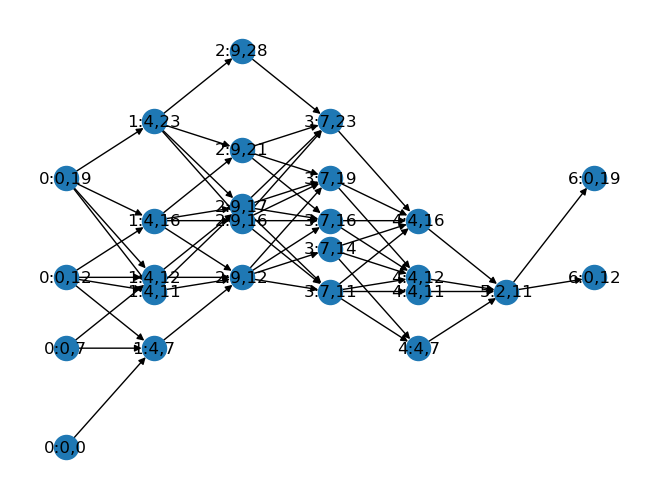

<Figure size 1800x1800 with 0 Axes>

In [17]:
import first

melody = [0,4,9,7,4,2,0]
melody_data = first.get_all_combos(melody, True)
print("melody data:", melody_data)

nodes_and_edges = find_nodes_and_edges(melody_data)
# deconstructing the variable with the following line led to the new variables being interpreted as strings: nodes, edges, final_index = nodes_and_edges
nodes = nodes_and_edges["nodes"]
edges = nodes_and_edges["edges"]
final_index = nodes_and_edges["final_index"]
print("nodes:", nodes)
print("edges:", edges)

network = make_network(nodes, edges, final_index)
print("network:", network)
visualize_network(network)
